In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import seaborn as sns
import statsmodels
import subprocess
import sys

sys.path.append(os.path.dirname(os.getcwd()))
import UKBB_traits

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import config_readwrite as crw
import fet
import split_filename
import plot_params as pp

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import chr_functions

pp.fonts()

('sans-serif', 'Arial', 18)

# load config 

In [2]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

REGIONS = config["CIS_TRANS"]["regions"]
REGION_ANNOT = config["CIS_TRANS"]["regions_annotations"]
PEAK_MAPPING = config["REGION_PEAK_OVERLAP"]["regions"]

PATH =  config["UKBB"]["path"]
RE = config["UKBB"]["results"]


# functions 

In [3]:
def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #hue = hue,
            linewidth=2.5, 
            #order = order,
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


    #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

    ax.set_xlabel("")

    #ax.get_yaxis().ticker.LogLocator(base=2)

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio, log2-scaled",  # y label
        title = title,
        ylim=ylim)
    return fig, ax

def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

In [4]:
def format_df(df):
    """
    return df w/ formatted columns
        Log2 OR
        Log2 CI
    """
    df["FC_log2"] = np.log2(df["FoldChange"].astype(float))
    df["ci_025_log2"] = np.log2(df["ci_025"].astype(float))
    df["ci_975_log2"] = np.log2(df["ci_975"].astype(float))
    
    return df

# load data 

In [5]:
fs = glob.glob(os.path.join(RE, "*LD_exp_uniq_nohla.tsv"))
len(fs)

29

In [6]:
results = {}
trait_d=UKBB_traits.trait_all_mapping()

for f in fs:
    path, filename, sid = split_filename.split_filename(f)
    
    trait = trait_d[sid.split("clean_LD_exp")[0]]

    df = pd.read_csv(f, sep = '\t')

    df["trait"]=trait

    df = df.loc[df["date_time"] !="date_time"] # clean up the dataframes. 
    
    float_cols = ["p-value", "FoldChange", "ci_025", "ci_975",  'StdDev',]
    df[float_cols] = df[float_cols].astype(float)

    df["ntotalvars_in_target"]=df["ntotalvars_in_target"].astype(int)
    
    df = format_df(df)
    
    results[trait] = df

    if len(df.loc[df["p-value"].astype(float)<0.1])>0:
        print(trait, df.loc[df["p-value"].astype(float)<0.1])

CHRONIC_LYMPHOID_LEUKEMIA     Observed  Expected     StdDev  FoldChange   p-value  \
3         23      13.0   6.434609    1.714286  0.096903   
7         42      28.0   8.482009    1.482759  0.088911   
9         49      28.0   9.117079    1.724138  0.039960   
10        25      10.0   5.262982    2.363636  0.029970   
13        97      60.0  12.554919    1.606557  0.012987   
14        97      69.0  13.551575    1.400000  0.044955   
15       161     110.0  15.252730    1.459459  0.005994   

                     date_time    ci_975    ci_025  iters  \
3   2022-08-08 13:11:12.031626  1.714286  1.828571   1000   
7   2022-08-08 13:11:18.803725  1.429803  1.482759   1000   
9   2022-08-08 13:11:19.513326  1.724138  1.781609   1000   
10  2022-08-08 13:11:19.320249  2.363636  2.560606   1000   
13  2022-08-08 13:11:38.441660  1.552098  1.606557   1000   
14  2022-08-08 13:11:43.661371  1.400000  1.419718   1000   
15  2022-08-08 13:11:57.821579  1.446192  1.472490   1000   

            

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


VIRAL_INFECTION     Observed  Expected     StdDev  FoldChange   p-value  \
17        56      77.0  12.662851    0.730769  0.095904   

                     date_time    ci_975    ci_025  iters  \
17  2022-08-08 13:10:50.282543  0.721279  0.730769   1000   

                                            sid  \
17  peaks-HH-active_MM-inactive_cis+trans_nohla   

                                     target  ntotalvars_in_target  \
17  phecode-079-both_sexesclean_LD_exp_uniq                 28703   

              trait   FC_log2  ci_025_log2  ci_975_log2  
17  VIRAL_INFECTION -0.452512    -0.452512    -0.471371  
LYMPHOID_LEUKEMIA     Observed  Expected     StdDev  FoldChange   p-value  \
4         53      24.0   7.091010    2.160000  0.002997   
6         23      11.0   5.180695    2.000000  0.038961   
9         29       9.0   4.309057    3.000000  0.000999   
12        27      16.0   5.988265    1.647059  0.073926   
16        92      52.0  10.323964    1.754717  0.001998   
17       125

ALZ    Observed  Expected    StdDev  FoldChange   p-value  \
4        21       9.0  4.792400    2.200000  0.033966   
7        39      25.0  7.579607    1.538462  0.071928   

                    date_time    ci_975    ci_025  iters  \
4  2022-08-08 12:56:49.588242  2.200000  2.400000   1000   
7  2022-08-08 12:56:51.211228  1.538462  1.595442   1000   

                                            sid  \
4  peaks-HH-active_MM-inactive_trans-only_nohla   
7                        peaks-trans_only_nohla   

                                       target  ntotalvars_in_target trait  \
4  phecode-290.11-both_sexesclean_LD_exp_uniq                 22850   ALZ   
7  phecode-290.11-both_sexesclean_LD_exp_uniq                 22850   ALZ   

    FC_log2  ci_025_log2  ci_975_log2  
4  1.137504     1.263034     1.137504  
7  0.621488     0.673956     0.621488  
PLATELET_COUNT     Observed  Expected      StdDev  FoldChange   p-value  \
6       1664    1415.0  138.227959    1.175847  0.069930   
11

In [7]:
df = pd.concat(results.values())
#df = df.loc[df["sid"].str.contains("no_hla")]
df = df.loc[~df["sid"].str.contains("peak")]
df = df.loc[~df["trait"].str.contains("AGE_COMPLETE")]

df.head()

,Observed,Expected,StdDev,FoldChange,p-value,date_time,ci_975,ci_025,iters,sid,target,ntotalvars_in_target,trait,FC_log2,ci_025_log2,ci_975_log2
1,0,1,1.896974,0.50,0.626374,2022-08-08 13:11:11.133182,0.50,0.50,1000,HH-active_MM-inactive_trans-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,-1.000000,-1.000000,-1.000000
2,1,1,2.692021,1.00,1.000000,2022-08-08 13:11:11.222000,1.00,1.00,1000,MM-active_HH-inactive_cis-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.000000,0.000000,0.000000
4,2,2,2.874435,1.00,1.000000,2022-08-08 13:11:14.314652,1.00,1.00,1000,MM-active_HH-inactive_trans-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.000000,0.000000,0.000000
6,3,3,3.223183,1.00,1.000000,2022-08-08 13:11:18.801455,1.00,1.00,1000,cis_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.000000,0.000000,0.000000
8,2,3,3.021300,0.75,0.766234,2022-08-08 13:11:18.902204,0.75,0.75,1000,trans_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,-0.415037,-0.415037,-0.415037


In [8]:
remove_sids = ['cis.regions','MM-active_HH-inactive_MH-inactive_trans',
       'MM-active_HH-inactive_HM-inactive_cis',
       'HH-active_MM-inactive_HM-inactive_trans', "trans.regions"]

df["sid2"] = df["sid"] + "-"+ df["trait"]


In [9]:
df["ci_025_log2"] = df["ci_025_log2"].replace(-np.inf, -1)
df["ci_975_log2"] = df["ci_975_log2"].replace(-np.inf, -1)
df["ci_025_log2"] = df["ci_025_log2"].replace(np.inf, 1)

In [10]:
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

# plot data

In [11]:
t = df.groupby("sid2")["trait"].count().reset_index()
inspect = t.loc[t.trait>1, "sid2"]

In [12]:
drop_index = df.loc[df.sid2.isin(inspect)].index[::2]

df = df.drop(drop_index)

df.head()

,Observed,Expected,StdDev,FoldChange,p-value,date_time,ci_975,ci_025,iters,sid,target,ntotalvars_in_target,trait,FC_log2,ci_025_log2,ci_975_log2,sid2
1,0,1,1.896974,0.50,0.626374,2022-08-08 13:11:11.133182,0.50,0.50,1000,HH-active_MM-inactive_trans-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,-1.000000,-1.000000,-1.000000,HH-active_MM-inactive_trans-only_nohla-CHRONIC...
2,1,1,2.692021,1.00,1.000000,2022-08-08 13:11:11.222000,1.00,1.00,1000,MM-active_HH-inactive_cis-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.000000,0.000000,0.000000,MM-active_HH-inactive_cis-only_nohla-CHRONIC_L...
4,2,2,2.874435,1.00,1.000000,2022-08-08 13:11:14.314652,1.00,1.00,1000,MM-active_HH-inactive_trans-only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.000000,0.000000,0.000000,MM-active_HH-inactive_trans-only_nohla-CHRONIC...
6,3,3,3.223183,1.00,1.000000,2022-08-08 13:11:18.801455,1.00,1.00,1000,cis_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,0.000000,0.000000,0.000000,cis_only_nohla-CHRONIC_LYMPHOID_LEUKEMIA
8,2,3,3.021300,0.75,0.766234,2022-08-08 13:11:18.902204,0.75,0.75,1000,trans_only_nohla,phecode-204.12-both_sexesclean_LD_exp_uniq,32884,CHRONIC_LYMPHOID_LEUKEMIA,-0.415037,-0.415037,-0.415037,trans_only_nohla-CHRONIC_LYMPHOID_LEUKEMIA


In [13]:
int_cols =['Observed',
 'Expected',
 'ntotalvars_in_target',
]


In [14]:
df.loc[df.trait=="ASTHMA"]

,Observed,Expected,StdDev,FoldChange,p-value,date_time,ci_975,ci_025,iters,sid,target,ntotalvars_in_target,trait,FC_log2,ci_025_log2,ci_975_log2,sid2
0,8,11,4.176568,0.750000,0.531469,2022-08-08 12:48:18.628674,0.750000,0.807692,1000,MM-active_HH-inactive_cis-only_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,-0.415037,-0.308122,-0.415037,MM-active_HH-inactive_cis-only_nohla-ASTHMA
11,17,16,5.193018,1.058824,0.925075,2022-08-08 14:14:02.614264,1.058824,1.117647,1000,MM-active_HH-inactive_trans-only_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.082462,0.160465,0.082462,MM-active_HH-inactive_trans-only_nohla-ASTHMA
12,8,9,3.868099,0.900000,0.866134,2022-08-08 14:14:33.871352,0.900000,0.900000,1000,HH-active_MM-inactive_trans-only_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,-0.152003,-0.152003,-0.152003,HH-active_MM-inactive_trans-only_nohla-ASTHMA
13,25,25,6.327786,1.000000,1.000000,2022-08-08 14:14:41.645205,0.960000,1.037037,1000,trans_only_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.000000,0.052467,-0.058894,trans_only_nohla-ASTHMA
14,27,38,7.942704,0.717949,0.175824,2022-08-08 14:14:42.174601,0.699055,0.717949,1000,conserved_active.regions_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,-0.478047,-0.478047,-0.516521,conserved_active.regions_nohla-ASTHMA
15,26,24,6.094515,1.080000,0.804196,2022-08-08 14:14:44.735147,1.035000,1.080000,1000,cis_only_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.111031,0.111031,0.049631,cis_only_nohla-ASTHMA
16,69,53.5,8.972319,1.284404,0.082917,2022-08-08 14:15:01.726175,1.272727,1.296296,1000,HH-active_MM-inactive_cis+trans_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.361099,0.374396,0.347923,HH-active_MM-inactive_cis+trans_nohla-ASTHMA
17,49,49,8.266971,1.000000,1.000000,2022-08-08 14:15:05.150592,0.979592,1.000000,1000,MM-active_HH-inactive_cis+trans_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.000000,0.000000,-0.029747,MM-active_HH-inactive_cis+trans_nohla-ASTHMA
18,18,12,4.408369,1.461538,0.201798,2022-08-08 14:15:23.875945,1.461538,1.461538,1000,HH-active_MM-inactive_cis-only_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.547488,0.547488,0.547488,HH-active_MM-inactive_cis-only_nohla-ASTHMA
19,118,103,11.390734,1.144231,0.206793,2022-08-08 14:15:29.425745,1.133122,1.155128,1000,cis+trans_nohla,categorical-20002-both_sexes-1111clean_LD_exp_...,185347,ASTHMA,0.194378,0.208053,0.180303,cis+trans_nohla-ASTHMA


# heatmap

In [15]:
# dictionary for sorting terms by activity category

order=[

'trans_only',
'cis_only',
'cis+trans',
'conserved_active.regions',

'HH-active_MM-inactive_trans-only',
'HH-active_MM-inactive_cis-only',
'HH-active_MM-inactive_cis+trans',

'MM-active_HH-inactive_trans-only',
'MM-active_HH-inactive_cis-only',
'MM-active_HH-inactive_cis+trans'
]

cross_walk = {}
for i, o in enumerate(order):
    cross_walk[o]=i

# add column labeling the categories
df["sid3"] = ""
for k, v in cross_walk.items():
    df.loc[df["sid"] == k, "sid3"]=v

table = pd.pivot(data = df, columns = ["trait", "ntotalvars_in_target"] , index = ["sid", "sid3"] , values = "FC_log2")

table = table.round(2)

ptable = pd.pivot(data = df, columns = ["trait", "ntotalvars_in_target"], index = ["sid", "sid3"], values = "p-value")
ptable=ptable.round(2)
ctable = pd.pivot(data = df, columns = ["trait", "ntotalvars_in_target"], index = ["sid", "sid3"], values = "Observed")


list(table)

[('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
 ('BILIARY_CIRROHSIS', 22108),
 ('HAY_FEVER_ALLERGIC_RHINITIS', 91521),
 ('WBC_COUNT', 563041),
 ('MS', 71646),
 ('CANCER_OTHER_LYMPHOID_HISTIOCYTIC', 29289),
 ('LYMPHOCYTE_COUNT', 631201),
 ('UC', 49484),
 ('COVID-19_HOSP', 11560),
 ('VIRAL_HEPC', 24801),
 ('TOBACCO_SMOKING_MOST_ALL_DAY', 17203),
 ('VIRAL_INFECTION', 28703),
 ('BREAST_CANCER', 72256),
 ('LYMPHOID_LEUKEMIA', 27474),
 ('NEUTROPHIL_PERCENTAGE', 465498),
 ('ASTHMA', 185347),
 ('HYPOTHYROIDISM', 168935),
 ('SCZ', 23531),
 ('MEAN_PLATELET_VOLUME', 946121),
 ('SLE', 46300),
 ('RA', 77191),
 ('ECZEMA', 53112),
 ('NHL', 37994),
 ('CROHNS', 27834),
 ('CELIAC_DISEASE', 136177),
 ('ALZ', 22850),
 ('PLATELET_COUNT', 854496),
 ('ATOPIC_DERMATITIS', 23246)]

In [16]:

new_tableorder = [
('ASTHMA', 185347),
('CELIAC_DISEASE', 136177),

('ECZEMA', 53112),
('HAY_FEVER_ALLERGIC_RHINITIS', 91521),
('MS', 71646),
('RA', 77191),
('SLE', 46300),
('UC', 49484),

('ATOPIC_DERMATITIS', 23246),
('BILIARY_CIRROHSIS', 22108),
('CROHNS', 27834),
('HYPOTHYROIDISM', 168935),

('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
('LYMPHOID_LEUKEMIA', 27474),
('CANCER_OTHER_LYMPHOID_HISTIOCYTIC', 29289),

('VIRAL_HEPC', 24801),    
('VIRAL_INFECTION', 28703),
('COVID-19_HOSP', 11560),
 ('LYMPHOCYTE_COUNT', 631201),
('NEUTROPHIL_PERCENTAGE', 465498),
('MEAN_PLATELET_VOLUME', 946121),
 ('WBC_COUNT', 563041),
 ('PLATELET_COUNT', 854496),


('BREAST_CANCER', 72256),
('NHL', 37994),
('TOBACCO_SMOKING_MOST_ALL_DAY', 17203),
('ALZ', 22850),
('SCZ', 23531)

] 
table = table[new_tableorder]
ptable=ptable[new_tableorder]
ctable=ctable[new_tableorder]

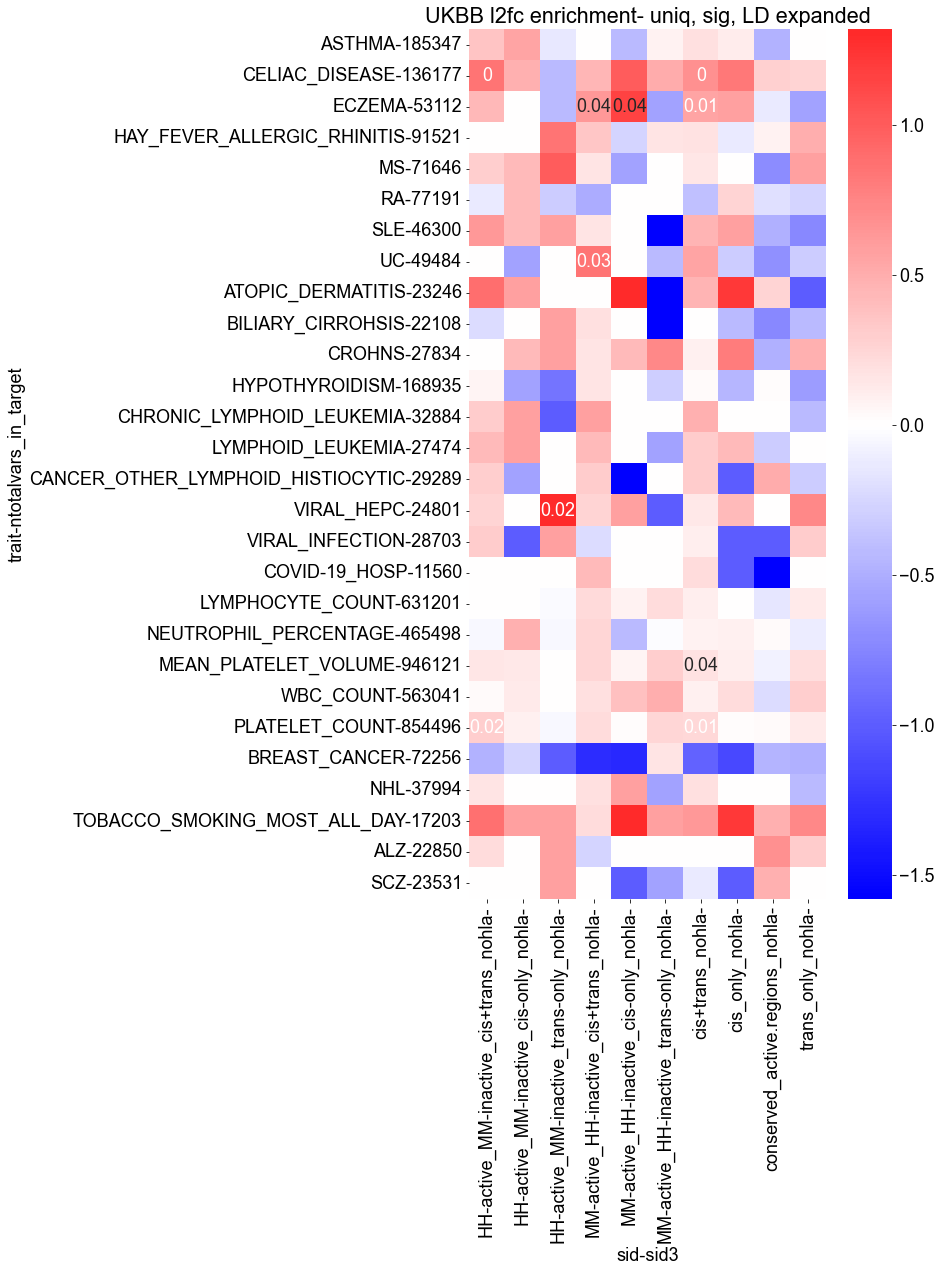

In [17]:
fig, ax = plt.subplots(figsize =(8,16))
sns.heatmap(table.T, cmap="bwr", center=0)
sns.heatmap(ptable.T,
            mask=ptable.T>=0.05, 
            #cmap="bwr", 
            center=0, alpha=0, annot=True, cbar=False)
plt.title("UKBB l2fc enrichment- uniq, sig, LD expanded")
out = os.path.join(RE, "UKBB_TRAITS_l2fc_heatmap-uniq-regions-ALL_nohla.pdf")
plt.savefig(out, bbox_inches="tight")

In [18]:
ctable =ctable.astype(int)

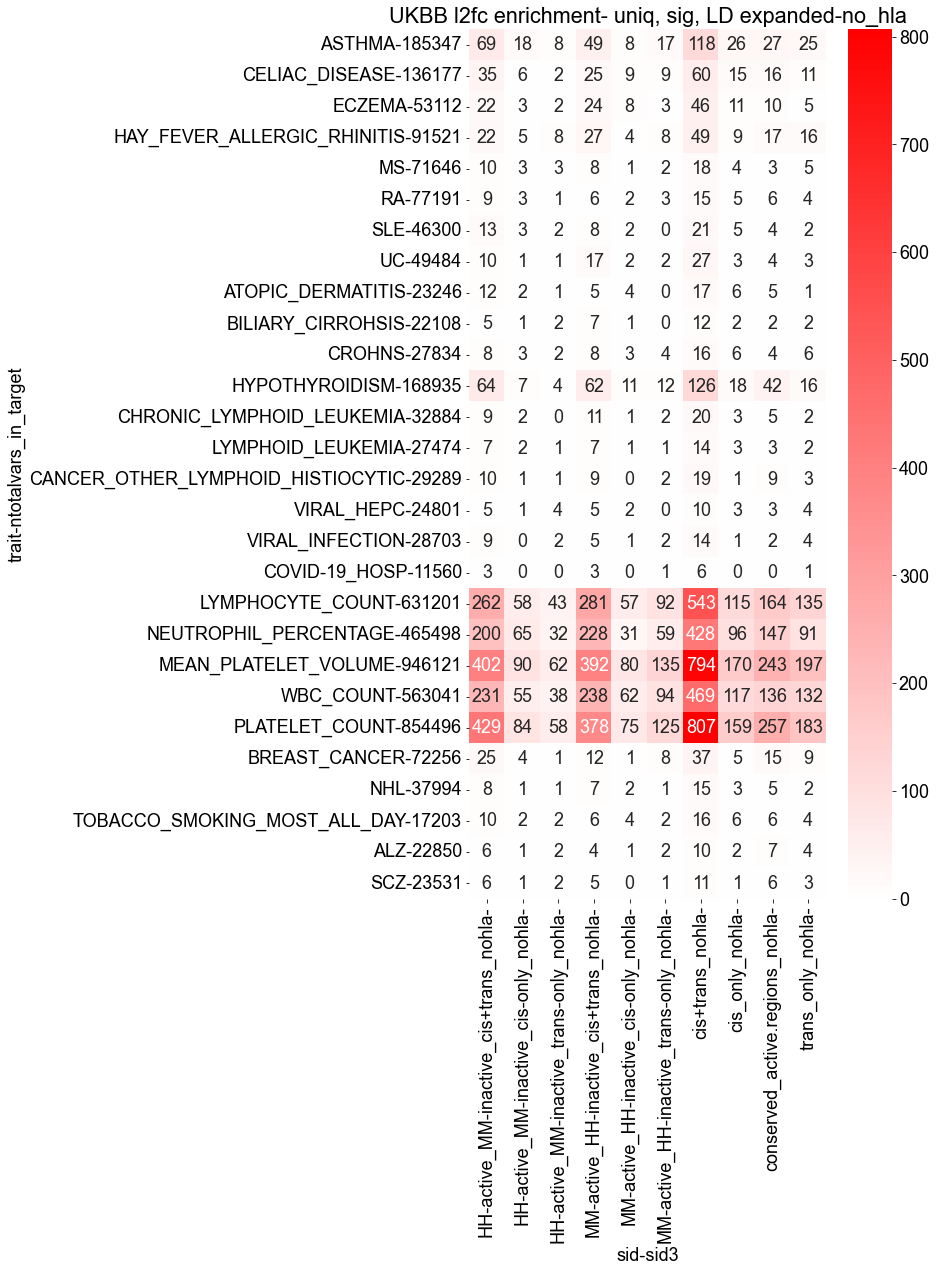

In [19]:
fig, ax = plt.subplots(figsize =(8,16))
sns.heatmap(ctable.T, cmap="bwr", center=0, annot = True, fmt="d")

plt.title("UKBB l2fc enrichment- uniq, sig, LD expanded-no_hla")
out = os.path.join(RE, "UKBB_TRAITS_l2fc_heatmap-uniq-regions-ALL_nohla_counts.pdf")
plt.savefig(out, bbox_inches="tight")

In [20]:
fig_tableorder = [
('ASTHMA', 185347),
('CELIAC_DISEASE', 136177),

('ECZEMA', 53112),
('HAY_FEVER_ALLERGIC_RHINITIS', 91521),
('MS', 71646),
('RA', 77191),
('SLE', 46300),
('UC', 49484),

('ATOPIC_DERMATITIS', 23246),
('BILIARY_CIRROHSIS', 22108),
('CROHNS', 27834),
('HYPOTHYROIDISM', 168935),

('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
('LYMPHOID_LEUKEMIA', 27474),
('CANCER_OTHER_LYMPHOID_HISTIOCYTIC', 29289),

('VIRAL_HEPC', 24801),    
#('VIRAL_INFECTION', 28703),
#('COVID-19_HOSP', 11560),
# ('LYMPHOCYTE_COUNT', 631201),
#('NEUTROPHIL_PERCENTAGE', 465498),
#('MEAN_PLATELET_VOLUME', 946121),
 ('WBC_COUNT', 563041),
 ('PLATELET_COUNT', 854496),


('BREAST_CANCER', 72256),
#('NHL', 37994),
('TOBACCO_SMOKING_MOST_ALL_DAY', 17203),
('ALZ', 22850),
('SCZ', 23531)


]



In [21]:
list(table)

[('ASTHMA', 185347),
 ('CELIAC_DISEASE', 136177),
 ('ECZEMA', 53112),
 ('HAY_FEVER_ALLERGIC_RHINITIS', 91521),
 ('MS', 71646),
 ('RA', 77191),
 ('SLE', 46300),
 ('UC', 49484),
 ('ATOPIC_DERMATITIS', 23246),
 ('BILIARY_CIRROHSIS', 22108),
 ('CROHNS', 27834),
 ('HYPOTHYROIDISM', 168935),
 ('CHRONIC_LYMPHOID_LEUKEMIA', 32884),
 ('LYMPHOID_LEUKEMIA', 27474),
 ('CANCER_OTHER_LYMPHOID_HISTIOCYTIC', 29289),
 ('VIRAL_HEPC', 24801),
 ('VIRAL_INFECTION', 28703),
 ('COVID-19_HOSP', 11560),
 ('LYMPHOCYTE_COUNT', 631201),
 ('NEUTROPHIL_PERCENTAGE', 465498),
 ('MEAN_PLATELET_VOLUME', 946121),
 ('WBC_COUNT', 563041),
 ('PLATELET_COUNT', 854496),
 ('BREAST_CANCER', 72256),
 ('NHL', 37994),
 ('TOBACCO_SMOKING_MOST_ALL_DAY', 17203),
 ('ALZ', 22850),
 ('SCZ', 23531)]

/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


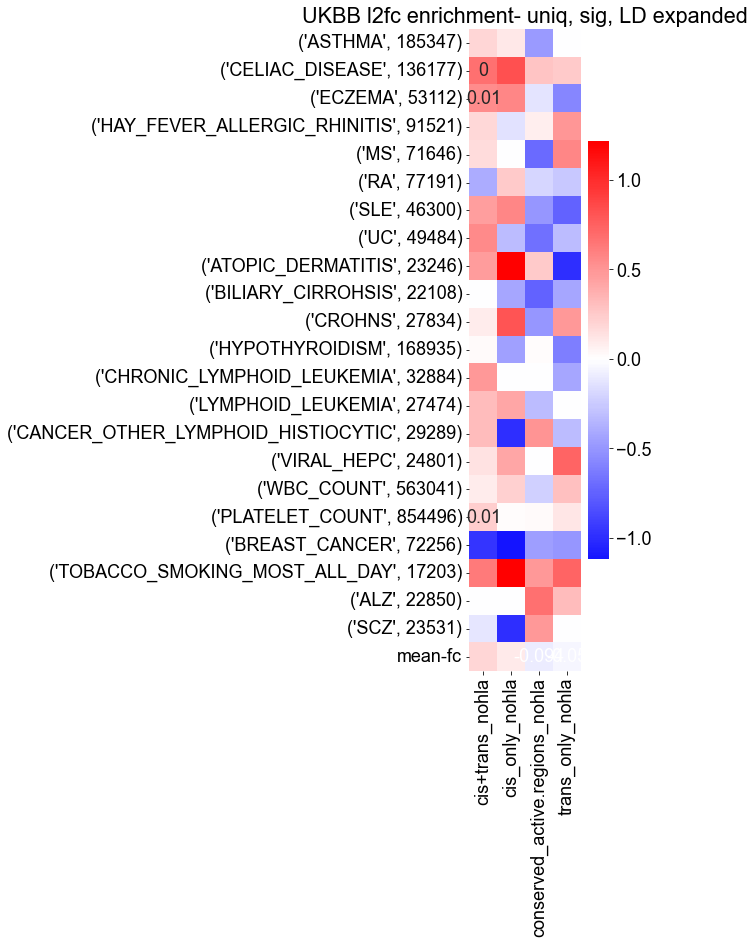

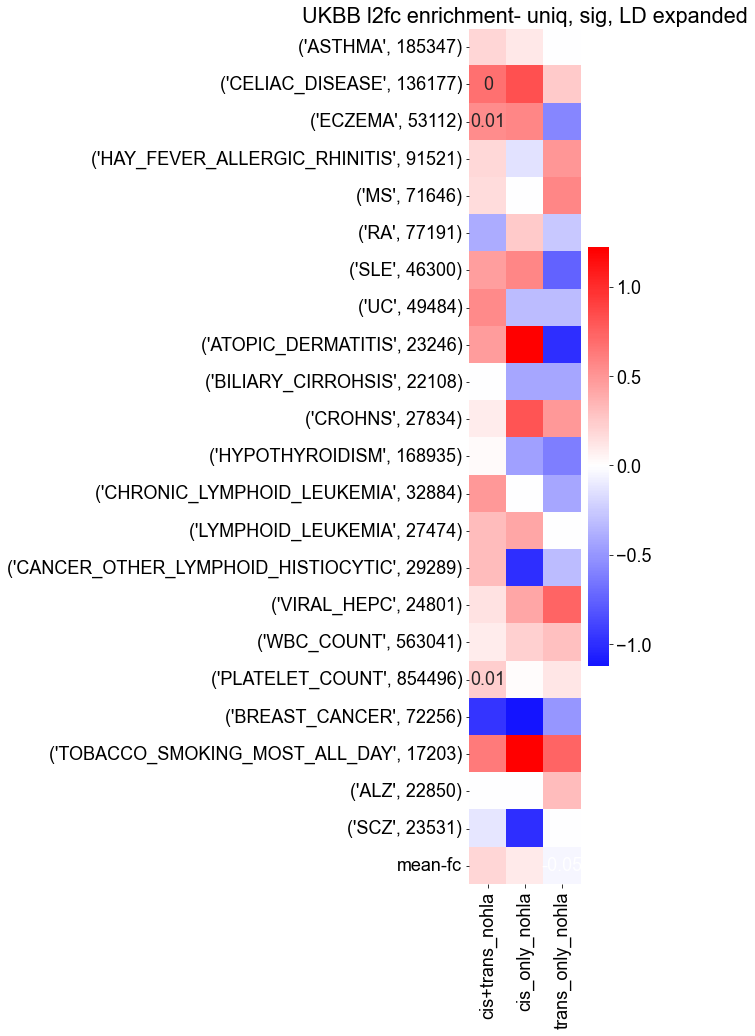

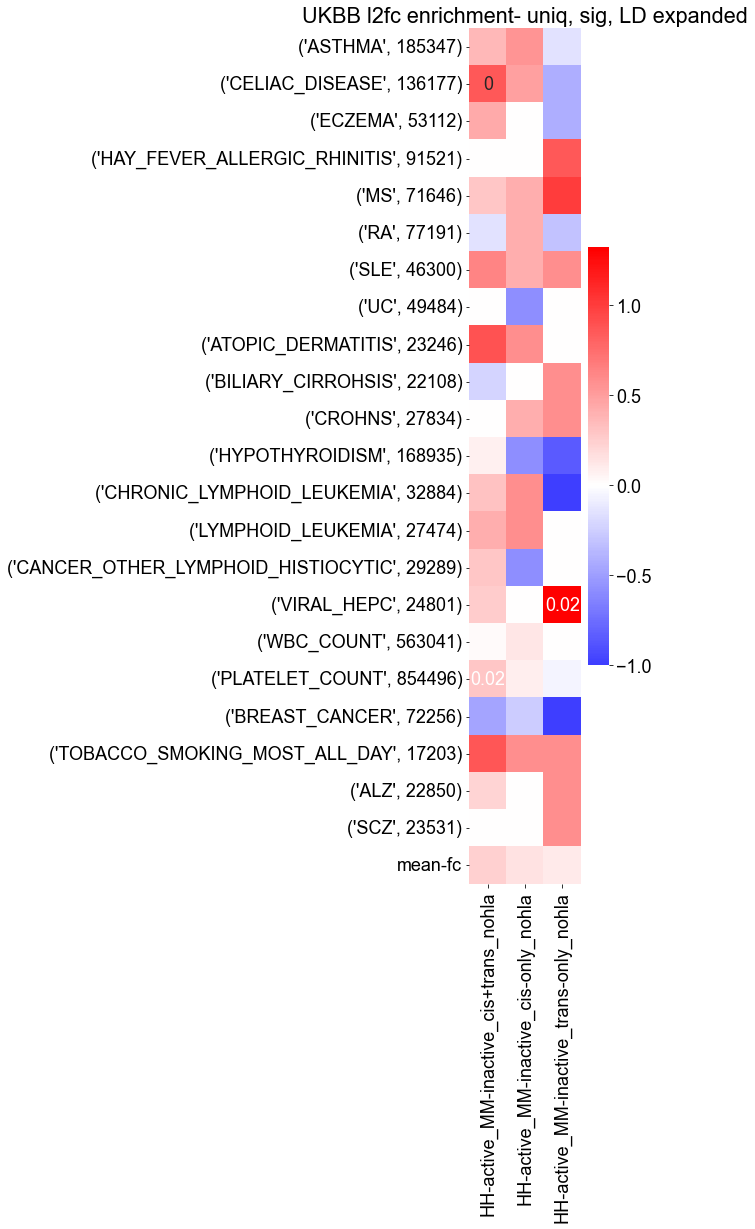

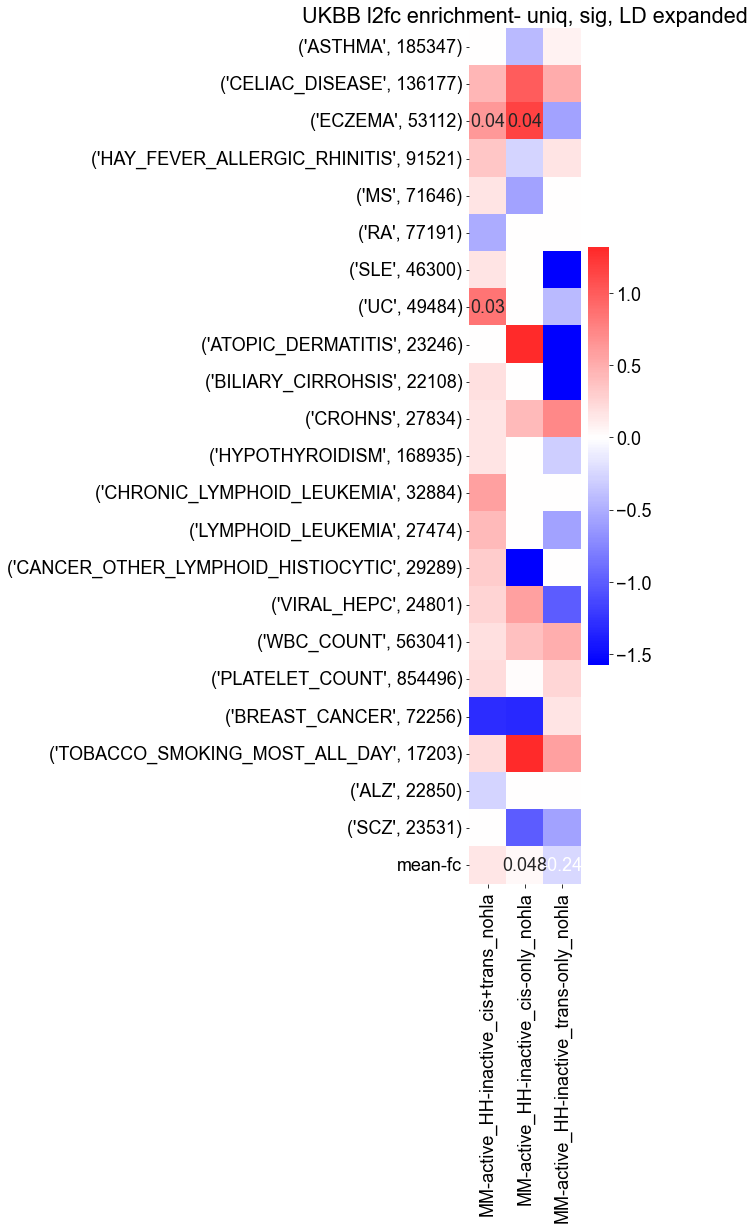

In [22]:
order_dict = {
            "all":[ "cis_only_nohla",  "trans_only_nohla","cis+trans_nohla","conserved_active.regions_nohla"], 
            "fig":['cis_only_nohla','trans_only_nohla','cis+trans_nohla'],
            "HH":['HH-active_MM-inactive_cis-only_nohla','HH-active_MM-inactive_trans-only_nohla','HH-active_MM-inactive_cis+trans_nohla'],
            "MM":['MM-active_HH-inactive_cis-only_nohla','MM-active_HH-inactive_trans-only_nohla','MM-active_HH-inactive_cis+trans_nohla']
}


# dictionary for sorting terms by activity category

for name, order in order_dict.items():

    table = pd.pivot(data = df.loc[df["sid"].isin(order)], 
                     index = ["sid"], 
                     columns = ["trait", "ntotalvars_in_target"], 
                     values = "FC_log2")

    table = table.round(2)

    ptable = pd.pivot(data = df.loc[df["sid"].isin(order)], 
                      index = ["sid"], 
                      columns = ["trait", "ntotalvars_in_target"], 
                      values = "p-value")
    ptable=ptable.round(2)


    table = table[fig_tableorder]
    ptable=ptable[fig_tableorder]
    
    # get the mean of the fold changes
    mean = table.mean(axis=1).reset_index()  # get the mean of the row
    mean=mean.rename(columns={0:"mean-fc"})
    mean =mean.set_index("sid")
    table=pd.merge(table,mean, left_index=True, right_index=True)
    ptable=pd.merge(ptable,mean, left_index=True, right_index=True)
    
    
    # plot
    fig, ax = plt.subplots(figsize =(2.5,16))
    sns.heatmap(table.T, cmap="bwr", center=0, square=True)
    sns.heatmap(ptable.T,mask=ptable.T>=0.05, cmap="bwr", center=0, alpha=0, annot=True, cbar=False)
    ax.set(title="UKBB l2fc enrichment- uniq, sig, LD expanded",
           xlabel = "",
           ylabel = ""
          )
    out = os.path.join(RE, f"UKBB_TRAITS_l2fc_heatmap-uniq-regions_{name}_fig_nohla.pdf")
    plt.savefig(out, bbox_inches="tight")